In [7]:

## 1-1. csv 파일에서 이미지 경로와 해당 이미지의 label 불러오기
## 1-1. Importing a image path and the image's label from csv file

import pandas as pd
import io 

csv_file_path = "./image-data/labels-map.csv"
lable_file = "512-common-hangul.txt"

csv_file = io.open(csv_file_path, 'r', encoding='utf-8-sig')
labels_file = io.open(lable_file, 'r', encoding='utf-8-sig').read().splitlines()

# Map characters to indices.
label_dict = {}
count = 0
for label in labels_file:
    label_dict[label] = count
    count += 1

# Build the lists.
filenames = []
labels = []
test1 = []
for row in csv_file:
    path, label = row.strip().split(',')
    filenames.append(path)
    labels.append(label_dict[label])
    test1.append(label)

print("csv file load finished")

csv file load finished


In [24]:
## 1-2. 두 개 리스트 랜덤으로 섞기
## 1-2. Shuffle two lists randomly

from subprocess import check_output
import random

seed = 1998

shuffled_indices = list(range(len(filenames)))
random.seed(seed)
random.shuffle(shuffled_indices)
filenames = [filenames[i] for i in shuffled_indices]
labels = [labels[i] for i in shuffled_indices]

print("List shuffle finished")

List shuffle finished


115
165
90
7
164


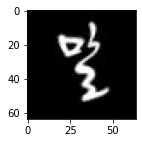

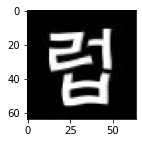

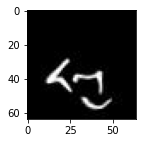

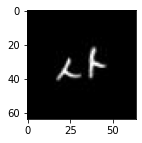

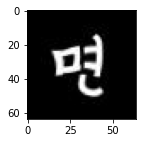

In [25]:
## 1-3. 이미지 경로의 이미지와 해당 label 시각화 
## 1-3. Visualize the image of the image path and its label

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(0, 5):
    print(labels[i])
    img = mpimg.imread(filenames[i])
    plt.figure(figsize=(2, 2))
    plt.imshow(img, cmap ='gray')

115


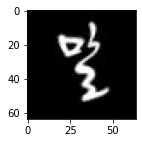

In [26]:
img = mpimg.imread(filenames[0])
plt.figure(figsize=(2, 2))
plt.imshow(img, cmap ='gray')
print(labels[0])

In [27]:
## 1-4. 이미지 경로에 있는 총 20,160개의 이미지 데이터 새로운 리스트에 담기
## 1-4. A total of 20,160 image data in the image path Add to a new list

import cv2

X_data = []

total_count = 0
prev_count = 0
  
for image_path in filenames:
    image = cv2.imread(image_path)
    X_data.append(image)
    total_count += 1
    
    if total_count - prev_count > 5000:
      prev_count = total_count
      print('{} images added...'.format(total_count))
    
print("Image adding finished")

5001 images added...
10002 images added...
15003 images added...
20004 images added...
25005 images added...
30006 images added...
35007 images added...
40008 images added...
Image adding finished


In [2]:
import numpy as np

X = np.array(X_data)
y = np.array(labels)

In [ ]:
import pickle

# colab에 쉽게 데이터를 올려서 사용하기 위함
# 로컬에서 실행시킬 경우 그냥 np.array한 데이터를 여기서 사용하면 됨
np.save('train_data', X)
np.save('train_label', y)

In [ ]:
# 이 이후의 실행 결과는 handwritten_hangul에 나와있음
# 이 이하는 코드만 기록함(colab에서 실행시켰기 때문)
## 1-5. 20,480 개의 데이터 훈련셋/검증셋/테스트셋 으로 나누기(비율 : r)
## 1-5. Divide by 20,480 data training set/verification/test sets(ratios: r)

# import numpy as np
from sklearn.model_selection import train_test_split

r = 0.20
# X = np.array(X_data)
# y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = r)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = r)
print("X_data:", X.shape)
print("y_labels:", y.shape)
print("\nX_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)

In [ ]:
## 2-1. Keras 모델 생성 및 훈련
## 2-1. Keras model initialization and training

import keras
import keras.utils as utils

from keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, ReLU
from tensorflow.keras.layers import BatchNormalization
import numpy as np
import os
import sys
from six.moves import cPickle
import matplotlib.pyplot as plt

In [ ]:
# 64*64의 이미지
batch_size = 64
epochs = 100

# 512개의 음절
num_classes = 512

In [ ]:
y_train = utils.to_categorical(y_train, num_classes)
y_val = utils.to_categorical(y_val, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [ ]:
X_train = X_train.astype('float32')
X_train /= 255
X_val = X_val.astype('float32')
X_val /= 255
X_test = X_test.astype('float32')
X_test /= 255

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=20,
        height_shift_range=0.2,
        width_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

In [ ]:
datagen.fit(X_train)

In [ ]:
# 논문을 찾아봤는데
# > CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC -> ....
# 순서로 진행하는게 좋다고 나와서 이대로 해봤음
# https://arxiv.org/pdf/1502.03167.pdf
# https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(64, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(MaxPooling2D(2, 2))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(512, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
opt = keras.optimizers.RMSprop(lr=0.001, decay=0.0)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
# train
history = model.fit(datagen.flow(X_train, y_train, batch_size = batch_size), 
            steps_per_epoch=len(X_train)/batch_size,
            epochs=epochs,
            validation_data = (X_val, y_val),
            workers=4)

In [ ]:
# validation accuracy와 accuracy를 비교하여 그래프로 표현해봄
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

# test 데이터에 모델을 적용시켜 예측을 진행했을 때의 accuracy를 알아보게 함
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

In [ ]:
# Save model and weights
save_dir = ('./')
model_name = 'trained_model2.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join('./', model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)